In [144]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np
import glob
import matplotlib.pyplot as plt

import enterprise
from enterprise.pulsar import Pulsar

import enterprise_extensions
from enterprise_extensions.frequentist import optimal_statistic

from simFuncs import *
from enterprisePTAs import crnPTA, mcSample
from OS_and_plotting import HandD,Dipole,Monopole,plotBinnedCrossCor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [235]:
parfiles = sorted(glob.glob('mdc2/*.par'))
obstimes = 53000.0 + np.linspace(0.0,20.0,520) * 365.25

ltpsrs = create_psrs(parfiles,obstimes,toaerr=0.01)

gwbamp = 1e-14
add_gwb(ltpsrs,amp=gwbamp)

fin = 10/(20*365.25*86400)


pdict = {'gwtheta': 1.75,
         'gwphi': 5.,
         'mc': 5e9,
         'dist': 60., 
         'fgw': fin,
         'phase0': 0.0,
         'psi': np.pi/4.0,
         'inc': 0.0}
    
add_cgw(ltpsrs, pdict, tref, iters=2)

psrs = lt2ent(ltpsrs)

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

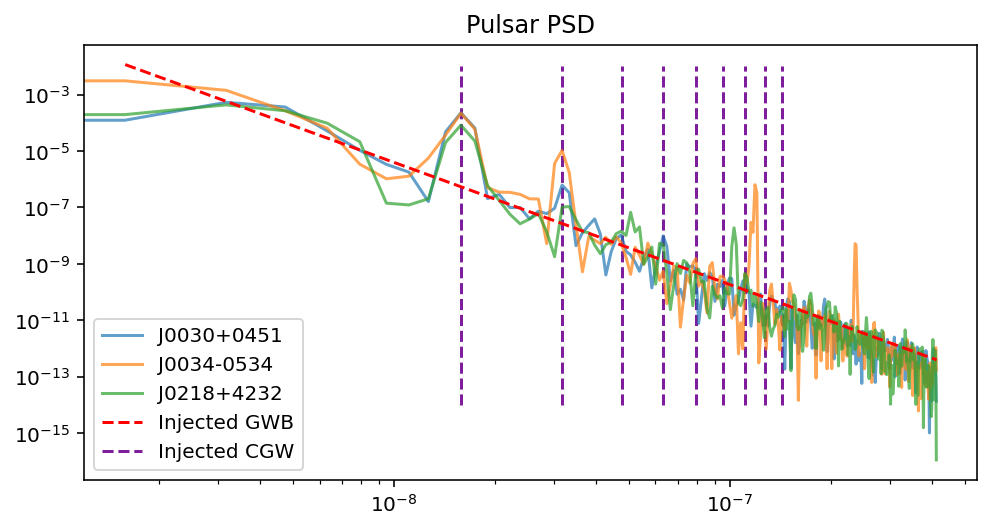

In [242]:
def plotPsrPsd(psr):
    from matplotlib import mlab
    from scipy import signal as sg
    
    toas = psr.toas
    res = psr.residuals
    
    fs = 1/(toas[1]-toas[0])

    NFFT=len(res)

    res *= sg.tukey(res.size, alpha=0.1)

    plt.title('Pulsar PSD')
    Pxx_0, freqs = mlab.psd(res, Fs = fs, NFFT = NFFT, detrend='none',scale_by_freq=True)
    plt.loglog(freqs, Pxx_0, ls='-', label=psr.name,alpha=0.7)
    plt.legend()

plt.figure(figsize=(8,4))
    
plotPsrPsd(psrs[0])
plotPsrPsd(psrs[1])
plotPsrPsd(psrs[2])

plt.vlines([i*fin for i in range(10)],1e-14,1e-2,colors='xkcd:purple',linestyles='dashed',label='Injected CGW')

yrs = 365.25*24*60*60
plfs = np.array([1,len(psrs[0].toas)/2])/(20*yrs)
#(freqs*365.25*24*3600)**(-13/3)*(365.25*24*3600)**3
plinj = (gwbamp**2/((12*np.pi**2)*(1/yrs)**3)) * (plfs/(1/yrs))**(-13/3)
plt.plot(plfs,plinj,'--r',label='Injected GWB')
plt.legend(loc='lower left')


In [3]:
pta = crnPTA(psrs,fixedGamma=True)

In [4]:
OS = optimal_statistic.OptimalStatistic(psrs,bayesephem=False,gamma_common=4.33,
                                        orf='hd',pta=pta)


In [5]:
xi,rho,sig,os,os_sig = OS.compute_os(params={'gw_log10_A':-14})
print(os,os_sig)
print(os/os_sig)

1.2761667844977113e-28 6.653690085121659e-30
19.179835071539515


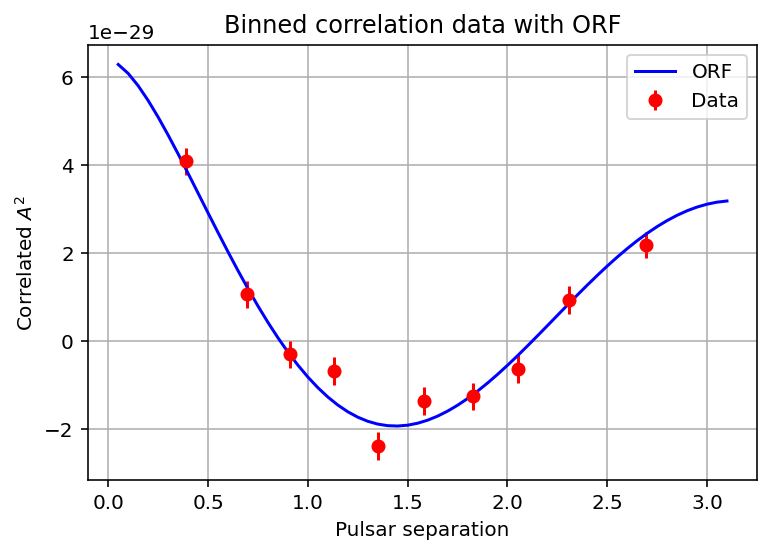

In [6]:
plotBinnedCrossCor(xi,rho,sig,os)

### Actual Runs

In [4]:
import healpy
import os
nside = 3
theta,phi = healpy.pix2ang(nside,np.arange(0,healpy.nside2npix(nside)))

In [ ]:
parfiles = sorted(glob.glob('mdc2/*.par'))
obstimes = 53000.0 + np.linspace(0.0,20.0,520) * 365.25
gwb_amp = 1e-14
toaerr = 0.1
tref = obstimes[0]*86400.0

xi = []
all_rhos = []
all_sigs = []
all_amps = []
all_ampsig = []
for ph,th in zip(phi,theta):
    rhos = []
    sigs = []
    amps = []
    ampsig = []

    for i in range(10):
        ltpsrs = create_psrs(parfiles,obstimes,toaerr=toaerr)
        add_gwb(ltpsrs,amp=gwb_amp)
    
    
        pdict = {'gwtheta': th,
                 'gwphi': ph,
                 'mc': 5e9,
                 'dist': 60., 
                 'fgw': 2e-8,
                 'phase0': 0.0,
                 'psi': np.pi/4.0,
                 'inc': 0.0}
    
        add_cgw(ltpsrs, pdict, tref, iters=5)
    
        psrs = lt2ent(ltpsrs)
    
        pta = crnPTA(psrs,fixedGamma=True)
        OS = optimal_statistic.OptimalStatistic(psrs,bayesephem=False,gamma_common=4.33,
                                            orf='hd',pta=pta)
    
        xi,rho,sig,os,os_sig = OS.compute_os(params={'gw_log10_A':-14})
        
        rhos.append(rho)
        sigs.append(sig)
        amps.append(os)
        ampsig.append(os_sig)
    all_rhos.append(rhos)
    all_sigs.append(sigs)
    all_amps.append(amps)
    all_ampsig.append(ampsig)

In [98]:
import numpy as np
import pandas as pd
import healpy
from healpy.newvisufunc import projview, newprojplot
import os

In [99]:
xiVals = []

nside = 5
theta,phi = healpy.pix2ang(nside,np.arange(0,healpy.nside2npix(nside)))
rhos = []
sigs = []

a_vals = []
a_sigs = []

for i in range(healpy.nside2npix(nside)):
    dirname = f'skylocation/results/run_nside{nside}_i{i}/'
    filename=dirname + [n for n in os.listdir(dirname) if 'data_hd'in n][0]
    test = pd.read_pickle(filename)
    xiVals = test['xi'].to_numpy()
    rhos.append(test['rho'].to_numpy())
    sigs.append(test['sig'].to_numpy())
    
    filename=dirname + [n for n in os.listdir(dirname) if 'params_hd'in n][0]
    with open(filename,'r') as f:
        lines = f.readlines()
        av = float(lines[1].split(' ')[1])
        asv = float(lines[0].split(' ')[1])
        a_vals.append(av)
        a_sigs.append(asv)
        
rhos = np.array(rhos)
sigs = np.array(sigs)

a_vals = np.array(a_vals)
a_sigs = np.array(a_sigs)

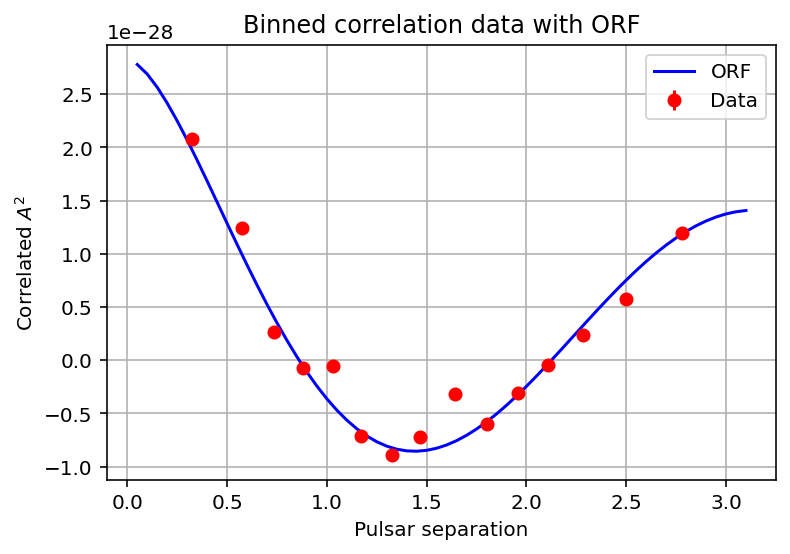

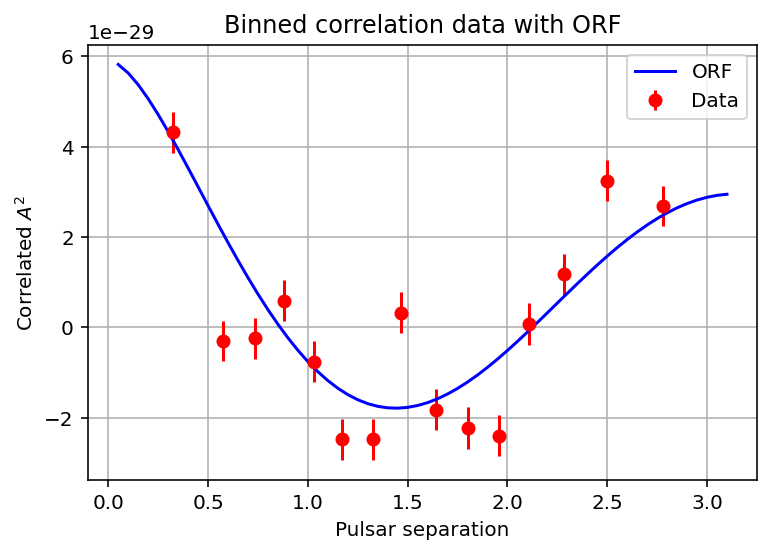

In [100]:
maxi = np.argmax(a_vals/a_sigs)
mini = np.argmin(a_vals/a_sigs)

plotBinnedCrossCor(xiVals,rhos[maxi],sigs[maxi],a_vals[maxi],bins=15)
plt.show()
plotBinnedCrossCor(xiVals,rhos[mini],sigs[mini],a_vals[mini],bins=15)
plt.show()

In [101]:
psr_theta = np.array([p.theta for p in psrs])
psr_phi = np.array([p.phi for p in psrs])
psr_phi[psr_phi>np.pi] -= 2*np.pi

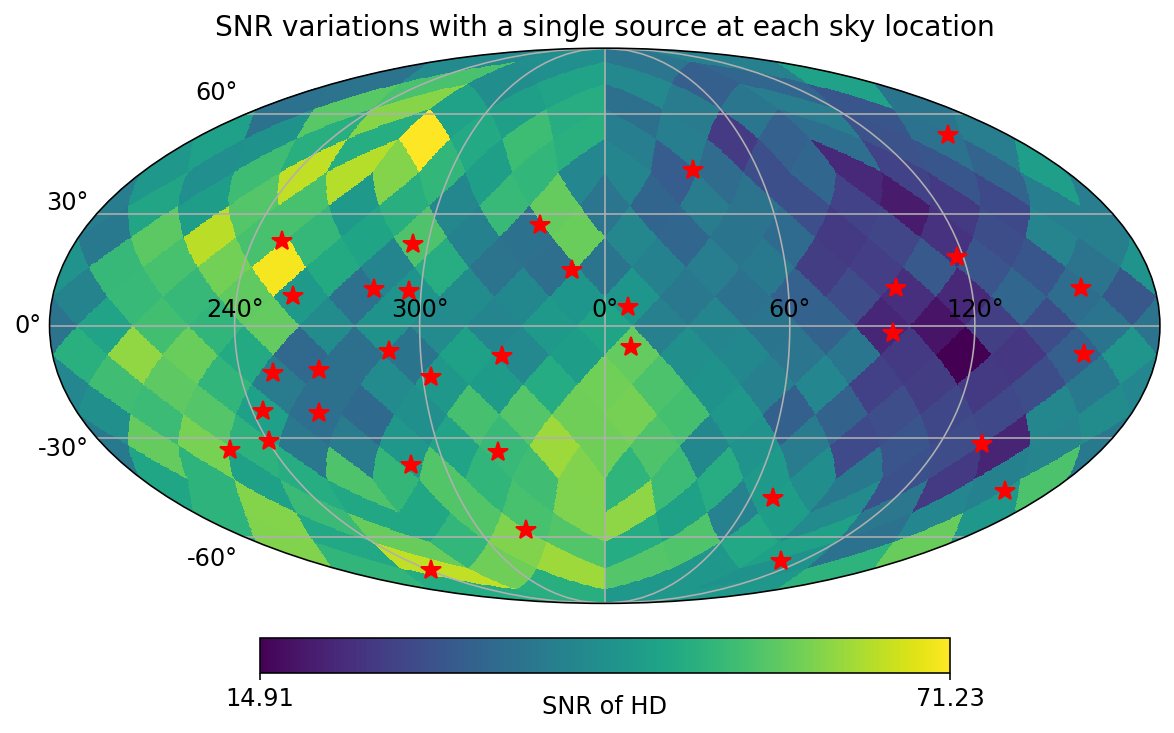

In [110]:
projview(a_vals/a_sigs,unit='SNR of HD',title='SNR variations with a single source at each sky location',
         
         graticule=True,graticule_labels=True,
         flip='geo',phi_convention='clockwise')
newprojplot(psr_theta,psr_phi,'r*',markersize=10,label='PSR positions')
#plt.legend()
plt.show()

### Check with no CGW

In [68]:
datadir = '/Users/gersbaka/Documents/Projects/VIPER_SummerSchool/mdc2'
resultsdir = '/Users/gersbaka/Documents/Projects/VIPER_SummerSchool'

parfiles = sorted(glob.glob(datadir + '/*.par'))

# define observation times and duration
Tobs = 20.0 # years
deltaT = 20.0 # points per year
obstimes = 53000.0 + np.arange(0.0, Tobs*365.25, 365.25/20.0)
tref = obstimes[0]*86400.0

xis = []
rhos= []
sigs= []

a_os= []
a_sigs= []


for i in range(10):
    psrs = create_psrs(parfiles, obstimes=obstimes)


    # add GWB to our pulsars
    # have the option of changing amplitude and spectral index (gamma)
    add_gwb(psrs)
    save_sims(psrs, outdir=resultsdir+f'/sims_no_source/sim{i}')
        
    psrs = lt2ent(psrs)
        
    pta = crnPTA(psrs,fixedGamma=True)
    
    OS = optimal_statistic.OptimalStatistic(psrs,bayesephem=False,gamma_common=4.33,
                                            orf='hd',pta=pta)

    xi,rho,sig,os,os_sig = OS.compute_os(params={'gw_log10_A':-14})
        
    xis = xi
    rhos.append(rho)
    sigs.append(sig)
    a_os.append(os)
    a_sigs.append(os_sig)


[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

In [71]:
a_os = np.array(a_os)
a_sigs = np.array(a_sigs)

In [73]:
print(a_os/a_sigs)
print(np.median(a_os/a_sigs))

[11.91232402 13.46103788 15.18000607 19.24387128 14.33250812 10.9934961
  8.26051206 13.17748026 10.86219888 10.69410145]
12.544902140037385


### Test with no GWB and just a single source

In [85]:
datadir = '/Users/gersbaka/Documents/Projects/VIPER_SummerSchool/mdc2'
resultsdir = '/Users/gersbaka/Documents/Projects/VIPER_SummerSchool'

parfiles = sorted(glob.glob(datadir + '/*.par'))

# define observation times and duration
Tobs = 20.0 # years
deltaT = 20.0 # points per year
obstimes = 53000.0 + np.arange(0.0, Tobs*365.25, 365.25/20.0)
tref = obstimes[0]*86400.0

xis = []
rhos= []
sigs= []

a_os= []
a_sigs= []


for i in range(1):
    psrs = create_psrs(parfiles, obstimes=obstimes)


    # add GWB to our pulsars
    # have the option of changing amplitude and spectral index (gamma)
    #add_gwb(psrs)
    
    pdict = {'gwtheta': 1.75,
             'gwphi': 5.,
             'mc': 5e9,
             'dist': 60., 
             'fgw': 2e-8,
             'phase0': 0.0,
             'psi': np.pi/4.0,
             'inc': 0.0}
    
    save_sims(psrs, outdir=resultsdir+f'/sims_only_source/sim{i}')
    add_cgw(psrs, pdict, tref, iters=2)
        
    psrs = lt2ent(psrs)
        
    pta = crnPTA(psrs,fixedGamma=True)
    
    OS = optimal_statistic.OptimalStatistic(psrs,bayesephem=False,gamma_common=4.33,
                                            orf='hd',pta=pta)

    xi,rho,sig,os,os_sig = OS.compute_os(params={'gw_log10_A':-14})
        
    xis = xi
    rhos.append(rho)
    sigs.append(sig)
    a_os.append(os)
    a_sigs.append(os_sig)


[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

In [86]:
a_os = np.array(a_os)
a_sigs = np.array(a_sigs)

In [87]:
print(a_os/a_sigs)
print(np.median(a_os/a_sigs))

[22.91366929]
22.913669293237866


In [123]:
def bincrosscorr(xi,rho,sig,bins=10):
    temp = np.arange(0,len(xi),len(xi)/bins,dtype=np.int16)
    ranges = np.zeros(bins+1)
    ranges[0:bins]=temp
    ranges[bins]=len(xi)
    
    xiAvg = np.zeros(bins)
    rhoAvg = np.zeros(bins)
    sigmaComb = np.zeros(bins)
    
    #Need to sort by pulsar separation
    sortMask = np.argsort(xi)
    
    for i in range(bins):
        #Mask and select range of values to average
        subXi = xi[sortMask]
        subXi = subXi[int(ranges[i]):int(ranges[i+1])]
        subRho = rho[sortMask]
        subRho = subRho[int(ranges[i]):int(ranges[i+1])]
        subSig = sig[sortMask]
        subSig = subSig[int(ranges[i]):int(ranges[i+1])]
        
        #Useful to not type this out every time
        subSigSquare = np.square(subSig)
        
        #Average the separations, no weighting
        xiAvg[i] = np.average(subXi)
        
        #Average the correlated amplitude, with weighting
        rhoAvg[i] = np.sum(subRho/subSigSquare)/np.sum(1/subSigSquare)
        
        #Averaging the uncertanties
        sigmaComb[i] = 1/np.sqrt(np.sum(1/subSigSquare))
        
    return xiAvg,rhoAvg,sigmaComb


<ErrorbarContainer object of 3 artists>

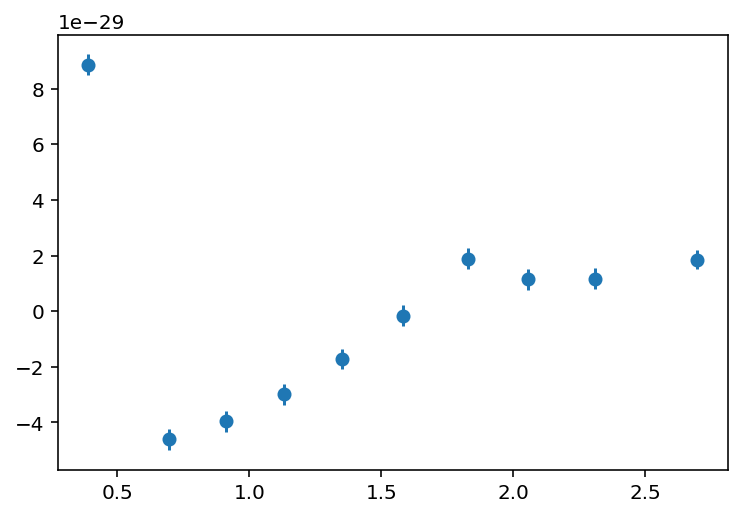

In [127]:
xiavg,rhoavg,sigavg = bincrosscorr(xi,rho,sig)
plt.errorbar(xiavg,rhoavg,sigavg,fmt='o')


1e-07